In [210]:
import numpy as np
import pandas as pd
import math
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Master Data Sets.ipynb")
from matplotlib import pyplot as plt
from ast import literal_eval
from sklearn.metrics.pairwise import haversine_distances
import itertools
from matplotlib import style
style.use('ggplot')
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from nltk.tokenize import word_tokenize
import re


In [2]:
train_cust =pd.read_csv('train_customers.csv',parse_dates=['created_at','updated_at'])
test_cust =pd.read_csv('test_customers.csv',parse_dates=['created_at','updated_at'])
train_loc =pd.read_csv('train_locations.csv')
test_loc =pd.read_csv('test_locations.csv')
vendors =pd.read_csv('vendors.csv',parse_dates=['created_at','updated_at'])
orders =pd.read_csv('orders.csv',parse_dates=['created_at','delivery_date'])
submission =pd.read_csv('SampleSubmission.csv')
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", 200)

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
## Reduce memory usage
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train_cust = reduce_mem_usage(train_cust)
test_cust = reduce_mem_usage(test_cust)
train_loc = reduce_mem_usage(train_loc)
test_loc = reduce_mem_usage(test_loc)
vendors = reduce_mem_usage(vendors)
orders = reduce_mem_usage(orders)
submission = reduce_mem_usage(submission)

Mem. usage decreased to  1.46 Mb (31.2% reduction)
Mem. usage decreased to  0.41 Mb (31.2% reduction)
Mem. usage decreased to  1.19 Mb (47.5% reduction)
Mem. usage decreased to  0.33 Mb (47.5% reduction)
Mem. usage decreased to  0.03 Mb (26.0% reduction)
Mem. usage decreased to 17.55 Mb (34.6% reduction)
Mem. usage decreased to 14.35 Mb (43.7% reduction)


In [5]:
train_cust= train_cust.rename({'akeed_customer_id': 'customer_id'}, axis=1)
test_cust= test_cust.rename({'akeed_customer_id': 'customer_id'}, axis=1)

In [6]:
test_cust = test_cust.drop_duplicates(subset='customer_id', keep="first")
train_cust = train_cust.drop_duplicates(subset='customer_id', keep="first")

In [7]:
'''


####.     HAVERSINE DISTANCE EQUATION FUNCTION      ####


'''

def haversine(lat1, lon1, lat2, lon2,to_radians=True, earth_radius=6371):
    

    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])
    
    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


In [8]:
dist1=train_loc[['customer_id','location_number','latitude','longitude']]
dist2=vendors[['id','latitude','longitude']]
dist=dist1.assign(key=1).merge(dist2.assign(key=1), on='key').drop('key',axis=1)

In [9]:
'''

        USING THE HAVERSINE FUNCTION TO FIND LAT-LONG DISTANCE FOR "TRAIN CUSTOMERS ~35,000"


'''
dist['distance'] = \
    haversine(dist['latitude_x'], dist['longitude_x'], dist['latitude_y'], dist['longitude_y'])

In [10]:
dist

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance
0,02SFNJH,0,1.682617,-78.812500,4,-0.588379,0.754395,8841.006836
1,02SFNJH,0,1.682617,-78.812500,13,-0.471680,0.744629,8841.006836
2,02SFNJH,0,1.682617,-78.812500,20,-0.407471,0.643555,8834.785156
3,02SFNJH,0,1.682617,-78.812500,23,-0.585449,0.753906,8841.006836
4,02SFNJH,0,1.682617,-78.812500,28,0.480713,0.552734,8828.563477
...,...,...,...,...,...,...,...,...
5950295,HWELAU8,1,-0.067017,0.648438,849,-1.587891,-0.066467,186.844818
5950296,HWELAU8,1,-0.067017,0.648438,855,2.144531,0.745117,245.950775
5950297,HWELAU8,1,-0.067017,0.648438,856,0.251465,0.483643,39.954849
5950298,HWELAU8,1,-0.067017,0.648438,858,0.019821,0.586914,12.048429


In [11]:
dist_des=dist['distance'].value_counts().rename_axis('distance').reset_index(name='counts')
dist_des.sort_values(by='distance', ascending=True)

,distance,counts
21,0.000000,8610
16,3.110840,9754
18,4.398922,9391
19,5.389287,8679
24,6.221680,7689
...,...,...
3793,15740.849609,106
3043,15765.736328,263
4823,15778.179688,12
5532,15877.726562,1


In [12]:
tdist1=test_loc[['customer_id','location_number','latitude','longitude']]
tdist2=vendors[['id','latitude','longitude']]
tdist=tdist1.assign(key=1).merge(tdist2.assign(key=1), on='key').drop('key',axis=1)

In [13]:
'''

        USING THE HAVERSINE FUNCTION TO FIND LAT-LONG DISTANCE FOR "TEST CUSTOMERS ~10,000"


'''
tdist['distance'] = \
    haversine(tdist['latitude_x'], tdist['longitude_x'], tdist['latitude_y'], tdist['longitude_y'])

In [14]:
tdist_des=tdist['distance'].value_counts().rename_axis('distance').reset_index(name='counts')
tdist_des.sort_values(by='distance', ascending=True)

,distance,counts
21,0.000000,2436
20,3.110840,2577
19,4.398922,2650
22,5.389287,2360
24,6.221680,2246
...,...,...
4985,15778.179688,2
5259,17980.654297,1
3269,18279.294922,55
3599,18329.068359,36


In [15]:
dist.sort_values(by='distance', ascending=True)

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance
5864139,3T6MND7,0,-1.048828,0.055206,180,-1.058594,0.051575,0.0
1410473,335L9OT,0,-0.826172,0.082520,356,-0.845215,0.067017,0.0
4748188,LWSZP1I,3,-0.128906,0.569336,676,-0.116150,0.570801,0.0
1483906,6A79SJT,0,-0.113464,0.563965,43,-0.114990,0.545898,0.0
3029711,2IFZSX6,1,-0.585449,0.751953,75,-0.600586,0.755859,0.0
...,...,...,...,...,...,...,...,...
5919895,O0LALCF,0,NaN,NaN,849,-1.587891,-0.066467,NaN
5919896,O0LALCF,0,NaN,NaN,855,2.144531,0.745117,NaN
5919897,O0LALCF,0,NaN,NaN,856,0.251465,0.483643,NaN
5919898,O0LALCF,0,NaN,NaN,858,0.019821,0.586914,NaN


In [16]:
tdist

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance
0,Z59FTQD,0,126.062500,-9.109375,4,-0.588379,0.754395,14011.222656
1,Z59FTQD,0,126.062500,-9.109375,13,-0.471680,0.744629,13998.779297
2,Z59FTQD,0,126.062500,-9.109375,20,-0.407471,0.643555,13998.779297
3,Z59FTQD,0,126.062500,-9.109375,23,-0.585449,0.753906,14011.222656
4,Z59FTQD,0,126.062500,-9.109375,28,0.480713,0.552734,13899.232422
...,...,...,...,...,...,...,...,...
1671995,3O8LSR3,0,-0.188599,0.827148,849,-1.587891,-0.066467,184.608902
1671996,3O8LSR3,0,-0.188599,0.827148,855,2.144531,0.745117,259.560699
1671997,3O8LSR3,0,-0.188599,0.827148,856,0.251465,0.483643,62.119583
1671998,3O8LSR3,0,-0.188599,0.827148,858,0.019821,0.586914,35.337196


In [17]:
tdist.describe()

,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance
count,1.672000e+06,1.671700e+06,1.671700e+06,1.672000e+06,1.672000e+06,1.672000e+06,1.671700e+06
mean,7.211124e-01,NaN,NaN,2.888400e+02,NaN,NaN,3.311909e+03
std,1.163812e+00,NaN,0.000000e+00,2.410855e+02,0.000000e+00,0.000000e+00,4.378828e+03
min,0.000000e+00,-6.715000e+02,-1.322500e+02,4.000000e+00,-1.787109e+00,-1.449219e+00,0.000000e+00
25%,0.000000e+00,-5.131836e-01,-7.850000e+01,1.057500e+02,-8.092041e-01,8.163452e-02,7.684747e+01
50%,0.000000e+00,-9.802246e-02,1.174164e-02,2.020000e+02,-4.934082e-01,5.270996e-01,1.541810e+02
75%,1.000000e+00,2.460938e-01,5.092773e-01,3.872500e+02,1.591873e-02,6.448975e-01,8.747682e+03
max,1.100000e+01,4.537500e+02,4.412500e+01,9.070000e+02,2.052500e+02,4.421875e+01,1.836640e+04


          distance  counts
0      8797.455078  312034
1      8741.459961  307539
2      8816.120117  289114
3      8747.681641  185643
4      8809.898438  140914
...            ...     ...
5859   3029.958008       1
5860   3033.068848       1
5861   3036.179688       1
5862   3037.735107       1
5863  16773.648438       1

[5864 rows x 2 columns]


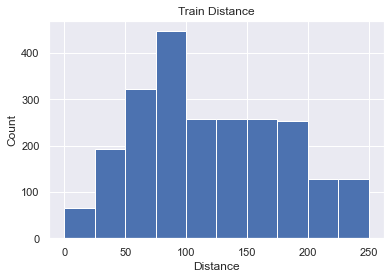

In [18]:
'''

        TRAIN CUSTOMER VENDOR DISTANCE DISTRIBUTION GRAPH.


'''
dist_des1=dist['distance'].value_counts().rename_axis('distance').reset_index(name='counts')
#dist_des1['%']=(dist_des1['counts']/5887889)*100
mean = np.mean(dist_des1['distance'])
sd = np.std(dist_des1['distance'])
dist_q = dist_des1[dist_des1['distance'] > mean - sd]
dist_q = dist_q[dist_q['distance'] < mean +  sd]
dist_q = dist_q[dist_q['distance'] < 250] 
dist_q.sort_values(by='distance', ascending=True)
x=dist_q['distance']
y=dist_q['counts']
plt.hist(x)
plt.grid=(True)
plt.title("Train Distance")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.show
print(dist_des1)

          distance  counts
0      8797.455078   89010
1      8741.459961   87496
2      8816.120117   81022
3      8747.681641   51948
4      8809.898438   39806
...            ...     ...
5277    921.586304       1
5278   2513.558594       1
5279   1066.240356       1
5280  10713.732422       1
5281    634.611328       1

[5282 rows x 2 columns]


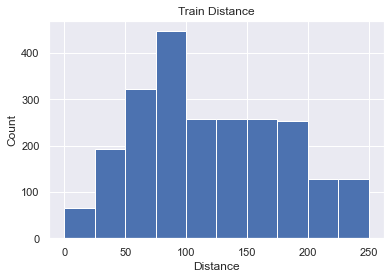

In [19]:
'''

        TEST CUSTOMER VENDOR DISTANCE DISTRIBUTION GRAPH.


'''
tdist_des1=tdist['distance'].value_counts().rename_axis('distance').reset_index(name='counts')
#tdist_des1['%']=(tdist_des1['counts']/1663653)*100
mean = np.mean(tdist_des1['distance'])
sd = np.std(tdist_des1['distance'])
tdist_q = tdist_des1[tdist_des1['distance'] > mean - sd]
tdist_q = tdist_q[tdist_q['distance'] < mean +  sd]
tdist_q = tdist_q[tdist_q['distance'] < 250] 
tdist_q.sort_values(by='distance', ascending=True)
x=tdist_q['distance']
y=tdist_q['counts']
plt.hist(x)
plt.grid=(True)
plt.title("Train Distance")
plt.xlabel("Distance")
plt.ylabel("Count")
plt.show
print(tdist_des1)

In [20]:
bin_list=[0,2,5,10,15,30,50,100,500,1000,5000,10000]

In [21]:
    dist4=dist[(dist['distance']>=(0))&(dist['distance']<=(5))]
    dist4=dist4['distance'].value_counts(bins=1).rename_axis('distance').reset_index(name='counts')
dist4

,distance,counts
0,"(-0.0054, 4.399]",27755


In [22]:
'''

        BINNING AND FINDING FREQUENCY OF TRAIN CUSTOMER VENDOR DISTANCE.


'''
dist5=pd.DataFrame(columns=['distance','counts'])
list_cycle = itertools.cycle(bin_list)
next(list_cycle)
for i in range(0,11):
    g=bin_list[i]
    next_element = next(list_cycle)
    dist4=dist[(dist['distance']>=(g))&(dist['distance']<=(next_element))]
    dist4=dist4['distance'].value_counts(bins=1).rename_axis('distance').reset_index(name='counts')
    dist5=dist5.append(dist4)
dist4=dist[(dist['distance']>=10000)]
dist4=dist4['distance'].value_counts(bins=1).rename_axis('distance').reset_index(name='counts')
dist5=dist5.append(dist4)
dist5['%']=(dist5['counts']/5887889)*100
dist5.reset_index(inplace = True) 
dist5.drop(columns=['index'])
dist5=dist5.drop(columns=['index'])
dist5.at[11,'distance']= '>10000'
dist5

,distance,counts,%
0,"(-0.002, 0.001]",8610,0.146232
1,"(3.109, 4.399]",19145,0.325159
2,"(5.3839999999999995, 9.837]",60127,1.0212
3,"(10.311, 14.922]",79041,1.34243
4,"(15.223, 29.99]",250747,4.25869
5,"(30.139999999999997, 49.968]",343935,5.8414
6,"(50.014, 99.936]",1392063,23.6428
7,"(99.63199999999999, 499.679]",1521310,25.838
8,"(499.567, 999.357]",3063,0.052022
9,"(997.7040000000001, 4986.676]",199218,3.38352


In [23]:
'''

        BINNING AND FINDING FREQUENCY OF TEST CUSTOMER VENDOR DISTANCE.


'''
tdist5=pd.DataFrame(columns=['distance','counts'])
list_cycle = itertools.cycle(bin_list)
next(list_cycle)
for i in range(0,11):
    g=bin_list[i]
    next_element = next(list_cycle)
    tdist4=tdist[(tdist['distance']>=(g))&(tdist['distance']<=(next_element))]
    tdist4=tdist4['distance'].value_counts(bins=1).rename_axis('distance').reset_index(name='counts')
    tdist5=tdist5.append(tdist4)
tdist4=tdist[(tdist['distance']>=10000)]
tdist4=tdist4['distance'].value_counts(bins=1).rename_axis('distance').reset_index(name='counts')
tdist5=tdist5.append(tdist4)
tdist5['%']=(tdist5['counts']/1663653)*100
tdist5.reset_index(inplace = True) 
tdist5=tdist5.drop(columns=['index'])
tdist5.at[11,'distance']= '>10000'
tdist5

,distance,counts,%
0,"(-0.002, 0.001]",2436,0.146425
1,"(3.109, 4.399]",5227,0.314188
2,"(5.3839999999999995, 9.837]",16888,1.01512
3,"(10.311, 14.922]",21799,1.31031
4,"(15.223, 29.99]",70240,4.22203
5,"(30.139999999999997, 49.968]",95997,5.77025
6,"(50.014, 99.936]",391515,23.5335
7,"(99.63199999999999, 499.679]",423337,25.4462
8,"(499.612, 954.25]",1092,0.0656387
9,"(1018.787, 3365.929]",56237,3.38033


In [24]:
dist

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance
0,02SFNJH,0,1.682617,-78.812500,4,-0.588379,0.754395,8841.006836
1,02SFNJH,0,1.682617,-78.812500,13,-0.471680,0.744629,8841.006836
2,02SFNJH,0,1.682617,-78.812500,20,-0.407471,0.643555,8834.785156
3,02SFNJH,0,1.682617,-78.812500,23,-0.585449,0.753906,8841.006836
4,02SFNJH,0,1.682617,-78.812500,28,0.480713,0.552734,8828.563477
...,...,...,...,...,...,...,...,...
5950295,HWELAU8,1,-0.067017,0.648438,849,-1.587891,-0.066467,186.844818
5950296,HWELAU8,1,-0.067017,0.648438,855,2.144531,0.745117,245.950775
5950297,HWELAU8,1,-0.067017,0.648438,856,0.251465,0.483643,39.954849
5950298,HWELAU8,1,-0.067017,0.648438,858,0.019821,0.586914,12.048429


In [25]:
'''

        APPENDING DELIVERY DISTANCE FROM ORDER DATASET TO THE ABOVE "dist"(TRAIN CUST) TABLE.


'''
dist['location_number_obj']=dist['location_number'].astype(str)
tdist['location_number_obj']=tdist['location_number'].astype(str)
dist['id_obj']=dist['id'].astype(str)
tdist['id_obj']=tdist['id'].astype(str)

In [26]:
dist['CID X LOC_NUM X VENDOR'] = dist['customer_id'] +' X '+ dist['location_number_obj'] +' X '+ dist['id_obj']
tdist['CID X LOC_NUM X VENDOR'] = tdist['customer_id'] +' X '+ tdist['location_number_obj'] +' X '+ tdist['id_obj']

In [27]:
serv_dist=orders[['CID X LOC_NUM X VENDOR','deliverydistance']]
serv_dist=serv_dist.groupby('CID X LOC_NUM X VENDOR').mean().reset_index()

In [28]:
dist =pd.merge(dist, serv_dist, on ='CID X LOC_NUM X VENDOR', how ='left')
tdist =pd.merge(tdist, serv_dist, on ='CID X LOC_NUM X VENDOR', how ='left')


In [29]:
'''

        DOING AWAY WITH THE NULL VALUES IN DELIVERY DISTANCE TO GET ONLY THE COMBINATION OF TRAIN CUST AND
        VENDORS WHO HAVE PLACED ORDERS.


'''
dist_notn= dist[dist['deliverydistance'].notnull()]
dist_notn

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance,location_number_obj,id_obj,CID X LOC_NUM X VENDOR,deliverydistance
143,02SFNJH,1,1.678711,0.766602,192,1.703125,0.759766,3.110840,1,192,02SFNJH X 1 X 192,0.409912
148,02SFNJH,1,1.678711,0.766602,199,2.337891,0.699707,73.688019,1,199,02SFNJH X 1 X 199,0.000000
196,02SFNJH,1,1.678711,0.766602,855,2.144531,0.745117,51.766319,1,855,02SFNJH X 1 X 855,4.218750
235,02SFNJH,2,-0.498535,0.661133,159,-0.600098,0.756348,15.554199,2,159,02SFNJH X 2 X 159,5.101562
397,RU43CXC,0,0.100830,0.438232,856,0.251465,0.483643,17.595688,0,856,RU43CXC X 0 X 856,3.679688
...,...,...,...,...,...,...,...,...,...,...,...,...
5950211,HWELAU8,1,-0.067017,0.648438,75,-0.600586,0.755859,60.564163,1,75,HWELAU8 X 1 X 75,6.839844
5950240,HWELAU8,1,-0.067017,0.648438,188,-0.405762,0.644531,37.718933,1,188,HWELAU8 X 1 X 188,5.750000
5950241,HWELAU8,1,-0.067017,0.648438,189,-0.856934,0.087708,107.712830,1,189,HWELAU8 X 1 X 189,0.000000
5950259,HWELAU8,1,-0.067017,0.648438,259,0.025818,0.551758,14.922310,1,259,HWELAU8 X 1 X 259,6.371094


In [30]:
dist5.reset_index(inplace = True) 
dist5.drop(columns=['index'])

,distance,counts,%
0,"(-0.002, 0.001]",8610,0.146232
1,"(3.109, 4.399]",19145,0.325159
2,"(5.3839999999999995, 9.837]",60127,1.0212
3,"(10.311, 14.922]",79041,1.34243
4,"(15.223, 29.99]",250747,4.25869
5,"(30.139999999999997, 49.968]",343935,5.8414
6,"(50.014, 99.936]",1392063,23.6428
7,"(99.63199999999999, 499.679]",1521310,25.838
8,"(499.567, 999.357]",3063,0.052022
9,"(997.7040000000001, 4986.676]",199218,3.38352


In [31]:
'''

        APPENDING ORDER NUMBER, ORDER PERCENTAGE TO THE CUSTOMER VENDOR COMBINATION AND MEAN DELIVERY DISTANCE 
        TO THE ABOVE TABLE.


'''
o=[]
o1=[]
list_cycle = itertools.cycle(bin_list)
next(list_cycle)
for i in range(0,11):
    g=bin_list[i]
    next_element = next(list_cycle)
    dist4=dist[(dist['distance']>=(g))&(dist['distance']<=(next_element))]
    dist4=dist4[dist4['deliverydistance'].notnull()]
    o.append(len(dist4))
    temp = np.mean(dist4['deliverydistance'])
    o1.append(temp)
dist4=dist[(dist['distance']>=10000)]
dist4=dist4[dist4['deliverydistance'].notnull()]
o.append(len(dist4))
temp = np.mean(dist4['deliverydistance'])
o1.append(temp)
dist5['order_no']=o
dist5['order_%']=(dist5['order_no']/dist5['counts'])*100
dist5['delivery_dist_mean']=o1

In [32]:
o1

[1.448, 1.966, 2.69, 3.66, 4.652, 5.57, inf, inf, 0.0, 0.0, 0.001397, 0.0903]

In [33]:
dist5

,index,distance,counts,%,order_no,order_%,delivery_dist_mean
0,0,"(-0.002, 0.001]",8610,0.146232,485,5.63298,1.448242
1,1,"(3.109, 4.399]",19145,0.325159,1169,6.10603,1.965820
2,2,"(5.3839999999999995, 9.837]",60127,1.0212,2935,4.88133,2.689453
3,3,"(10.311, 14.922]",79041,1.34243,3211,4.06245,3.660156
4,4,"(15.223, 29.99]",250747,4.25869,9154,3.65069,4.652344
5,5,"(30.139999999999997, 49.968]",343935,5.8414,10125,2.94387,5.570312
6,6,"(50.014, 99.936]",1392063,23.6428,18888,1.35684,inf
7,7,"(99.63199999999999, 499.679]",1521310,25.838,10328,0.678889,inf
8,8,"(499.567, 999.357]",3063,0.052022,12,0.391773,0.000000
9,9,"(997.7040000000001, 4986.676]",199218,3.38352,4,0.00200785,0.000000


<function matplotlib.pyplot.show(*args, **kw)>

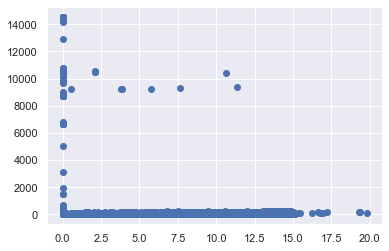

In [34]:
x=dist_notn['deliverydistance']
y=dist_notn['distance']
plt.scatter(x,y)
plt.show

In [35]:
dist_notn.describe()

,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance,deliverydistance
count,80142.000000,80137.000000,80137.000000,80142.000000,80142.000000,80142.000000,80137.000000,80142.000000
mean,0.839136,-0.095459,NaN,247.258441,NaN,0.625488,2655.472168,NaN
std,1.251256,NaN,0.000000,230.270831,0.000000,0.000000,3998.546875,0.000000
min,0.000000,-671.500000,-134.375000,4.000000,-1.787109,-1.449219,0.000000,0.000000
25%,0.000000,-0.442871,-78.500000,84.000000,-0.845215,0.080811,36.139210,0.000000
50%,0.000000,-0.087158,0.011909,159.000000,-0.523926,0.482422,82.242828,2.820312
75%,1.000000,0.178955,0.506348,304.000000,0.019821,0.605469,8741.459961,7.511719
max,25.000000,453.750000,44.093750,907.000000,205.250000,44.218750,14558.730469,19.812500


In [36]:
mean = np.mean(dist_notn['distance'])
sd = np.std(dist_notn['distance'])
print(mean)
print(sd)

2655.47216796875
3998.52197265625


In [37]:
'''

        FILTERING ONLY THOSE POINTS WITHIN ONE STANDARD DEVIATION FROM THE MEAN (68%) REST ARE CONSIDERED OUTLIERS 


'''
dist_f = dist_notn[dist_notn['distance'] > mean - sd]
dist_f = dist_f[dist_f['distance'] < mean +  sd]

In [38]:
dist_f 

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance,location_number_obj,id_obj,CID X LOC_NUM X VENDOR,deliverydistance
143,02SFNJH,1,1.678711,0.766602,192,1.703125,0.759766,3.110840,1,192,02SFNJH X 1 X 192,0.409912
148,02SFNJH,1,1.678711,0.766602,199,2.337891,0.699707,73.688019,1,199,02SFNJH X 1 X 199,0.000000
196,02SFNJH,1,1.678711,0.766602,855,2.144531,0.745117,51.766319,1,855,02SFNJH X 1 X 855,4.218750
235,02SFNJH,2,-0.498535,0.661133,159,-0.600098,0.756348,15.554199,2,159,02SFNJH X 2 X 159,5.101562
397,RU43CXC,0,0.100830,0.438232,856,0.251465,0.483643,17.595688,0,856,RU43CXC X 0 X 856,3.679688
...,...,...,...,...,...,...,...,...,...,...,...,...
5950211,HWELAU8,1,-0.067017,0.648438,75,-0.600586,0.755859,60.564163,1,75,HWELAU8 X 1 X 75,6.839844
5950240,HWELAU8,1,-0.067017,0.648438,188,-0.405762,0.644531,37.718933,1,188,HWELAU8 X 1 X 188,5.750000
5950241,HWELAU8,1,-0.067017,0.648438,189,-0.856934,0.087708,107.712830,1,189,HWELAU8 X 1 X 189,0.000000
5950259,HWELAU8,1,-0.067017,0.648438,259,0.025818,0.551758,14.922310,1,259,HWELAU8 X 1 X 259,6.371094


<function matplotlib.pyplot.show(*args, **kw)>

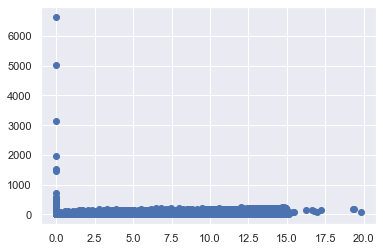

In [39]:
x=dist_f['deliverydistance']
y=dist_f['distance']
plt.scatter(x,y)
plt.show

In [40]:
'''

        FURTHER FILTERING OUT POINTS IN THE 0 DELIVERY DISTANCE WHICH ARE SKEWING THE GRAPH
        
'''
dist_f = dist_f[dist_f['distance'] < 250] 
dist_f = dist_f[dist_f['deliverydistance'] < 15]

<function matplotlib.pyplot.show(*args, **kw)>

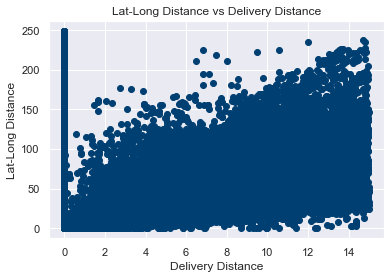

In [41]:
'''

        LAT-LONG DISTANCE VS DELIVERY DISTANCE GRAPH.


'''
x=dist_f['deliverydistance']
y=dist_f['distance']
plt.scatter(x,y,color='#003F72')
plt.title("Lat-Long Distance vs Delivery Distance")
plt.xlabel("Delivery Distance")
plt.ylabel("Lat-Long Distance")
plt.show

In [42]:
dist_f.shape

(55939, 12)

In [43]:
'''

        FINDING THE BEST FIT LINE.


'''
from statistics import mean
def best_fit_slope_and_intercept(x,y):
    m = (((mean(x)*mean(y)) - mean(x*y)) /
         ((mean(x)*mean(x)) - mean(x*x)))
    
    b = mean(y) - m*mean(x)
    
    return m, b

m, b = best_fit_slope_and_intercept(x,y)

print(m,b)

3.2205422521992477 40.85875809749538


In [44]:
regression_line = [(m*x)+b for x in x]

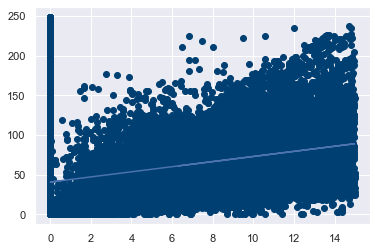

In [45]:
plt.scatter(x,y,color='#003F72')
plt.plot(x, regression_line)
plt.show()

In [46]:
dist_f

,customer_id,location_number,latitude_x,longitude_x,id,latitude_y,longitude_y,distance,location_number_obj,id_obj,CID X LOC_NUM X VENDOR,deliverydistance
143,02SFNJH,1,1.678711,0.766602,192,1.703125,0.759766,3.110840,1,192,02SFNJH X 1 X 192,0.409912
148,02SFNJH,1,1.678711,0.766602,199,2.337891,0.699707,73.688019,1,199,02SFNJH X 1 X 199,0.000000
196,02SFNJH,1,1.678711,0.766602,855,2.144531,0.745117,51.766319,1,855,02SFNJH X 1 X 855,4.218750
235,02SFNJH,2,-0.498535,0.661133,159,-0.600098,0.756348,15.554199,2,159,02SFNJH X 2 X 159,5.101562
397,RU43CXC,0,0.100830,0.438232,856,0.251465,0.483643,17.595688,0,856,RU43CXC X 0 X 856,3.679688
...,...,...,...,...,...,...,...,...,...,...,...,...
5950211,HWELAU8,1,-0.067017,0.648438,75,-0.600586,0.755859,60.564163,1,75,HWELAU8 X 1 X 75,6.839844
5950240,HWELAU8,1,-0.067017,0.648438,188,-0.405762,0.644531,37.718933,1,188,HWELAU8 X 1 X 188,5.750000
5950241,HWELAU8,1,-0.067017,0.648438,189,-0.856934,0.087708,107.712830,1,189,HWELAU8 X 1 X 189,0.000000
5950259,HWELAU8,1,-0.067017,0.648438,259,0.025818,0.551758,14.922310,1,259,HWELAU8 X 1 X 259,6.371094


In [47]:

dist5

,index,distance,counts,%,order_no,order_%,delivery_dist_mean
0,0,"(-0.002, 0.001]",8610,0.146232,485,5.63298,1.448242
1,1,"(3.109, 4.399]",19145,0.325159,1169,6.10603,1.965820
2,2,"(5.3839999999999995, 9.837]",60127,1.0212,2935,4.88133,2.689453
3,3,"(10.311, 14.922]",79041,1.34243,3211,4.06245,3.660156
4,4,"(15.223, 29.99]",250747,4.25869,9154,3.65069,4.652344
5,5,"(30.139999999999997, 49.968]",343935,5.8414,10125,2.94387,5.570312
6,6,"(50.014, 99.936]",1392063,23.6428,18888,1.35684,inf
7,7,"(99.63199999999999, 499.679]",1521310,25.838,10328,0.678889,inf
8,8,"(499.567, 999.357]",3063,0.052022,12,0.391773,0.000000
9,9,"(997.7040000000001, 4986.676]",199218,3.38352,4,0.00200785,0.000000


In [48]:
k=pd.Series(dist5['%'])

In [49]:
k.sum()

101.0497990026646

In [50]:
'''

        FINDING THE MEAN STD MIN AND MAX FOR THE DELIVERY DISTANCE.


'''
serv_dist=dist_f[['CID X LOC_NUM X VENDOR','deliverydistance']]
latlong_dist=dist_f[['CID X LOC_NUM X VENDOR','distance']]
latlong_dist1=latlong_dist.drop_duplicates(subset='CID X LOC_NUM X VENDOR', keep="first").reset_index()
serv_dist1=serv_dist.groupby('CID X LOC_NUM X VENDOR').mean().reset_index()
serv_dist1=serv_dist1.rename(columns={'deliverydistance':'mean'})
serv_dist2=serv_dist.groupby('CID X LOC_NUM X VENDOR').std().reset_index()
serv_dist2=serv_dist2.rename(columns={'deliverydistance':'std'})
serv_dist3=serv_dist.groupby('CID X LOC_NUM X VENDOR').min().reset_index()
serv_dist3=serv_dist3.rename(columns={'deliverydistance':'min'})
serv_dist4=serv_dist.groupby('CID X LOC_NUM X VENDOR').max().reset_index()
serv_dist4=serv_dist4.rename(columns={'deliverydistance':'max'})
serv_dist5=orders['CID X LOC_NUM X VENDOR'].value_counts().rename_axis('CID X LOC_NUM X VENDOR').reset_index(name='counts')
CLV_freq =pd.merge(latlong_dist1,serv_dist5, on ='CID X LOC_NUM X VENDOR', how ='left')
CLV_freq =pd.merge(CLV_freq,serv_dist1, on ='CID X LOC_NUM X VENDOR', how ='left')
CLV_freq =pd.merge(CLV_freq,serv_dist2, on ='CID X LOC_NUM X VENDOR', how ='left')
CLV_freq =pd.merge(CLV_freq,serv_dist3, on ='CID X LOC_NUM X VENDOR', how ='left')
CLV_freq =pd.merge(CLV_freq,serv_dist4, on ='CID X LOC_NUM X VENDOR', how ='left')
CLV_freq=CLV_freq.sort_values(by='counts', ascending=False).reset_index()
CLV_freq=CLV_freq.drop(columns=['index','level_0'])
CLV_freq

,CID X LOC_NUM X VENDOR,distance,counts,mean,std,min,max
0,XW90EAP X 3 X 13,17.875177,69,1.514648,NaN,1.514648,1.514648
1,KXXRD9J X 2 X 157,0.000000,62,1.351562,NaN,1.351562,1.351562
2,3W4JVGN X 1 X 303,8.232789,61,3.222656,NaN,3.222656,3.222656
3,A46KPEA X 1 X 157,47.999287,49,6.597656,NaN,6.597656,6.597656
4,HSKCXYG X 1 X 113,48.801300,46,6.523438,NaN,6.523438,6.523438
...,...,...,...,...,...,...,...
55934,RLC32ZB X 0 X 398,27.657310,1,14.242188,NaN,14.242188,14.242188
55935,RLC32ZB X 0 X 849,98.088669,1,7.261719,NaN,7.261719,7.261719
55936,2HT7RZV X 0 X 43,15.238255,1,3.750000,NaN,3.750000,3.750000
55937,YCHG7IM X 1 X 43,83.992676,1,9.429688,NaN,9.429688,9.429688


In [51]:
'''

        IT IS NOTICED THAT THERE IS NO DEVIAION OF DELIVERY DISTANCE FOR MULTIPLE ORDER, THERE IS CONSISTENCY
        IN DELIVERY DISTANCE FOR A CUSTOMER WHO IS ORDERING FROM THE SAME VENDOR MULTIPLE TIMES.


'''
serv_dist21=serv_dist2[serv_dist2['std'].notnull()]
serv_dist21

,CID X LOC_NUM X VENDOR,std


Text(0, 0.5, 'Latitude')

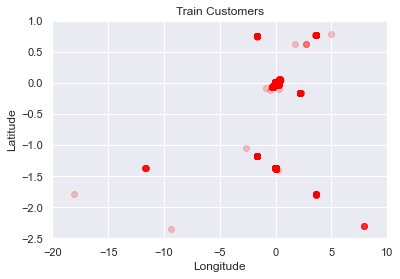

In [52]:
'''

        TRAIN CUSTOMERS LAT LONG PLOT

'''
trainLY=[np.radians(train_loc['longitude'])]
trainLX=[np.radians(train_loc['latitude'])]
plt.scatter(trainLX,trainLY, color="red", alpha=0.2)
plt.xlim(-20,10)
plt.ylim(-2.5,1)
plt.title("Train Customers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Text(0, 0.5, 'Latitude')

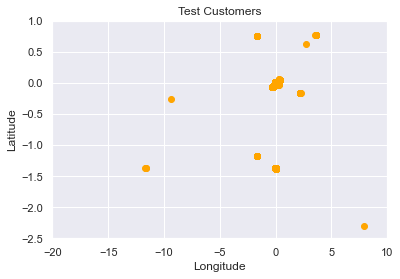

In [53]:
'''

        TEST CUSTOMERS LAT LONG PLOT

'''
testLY=[np.radians(test_loc['longitude'])]
testLX=[np.radians(test_loc['latitude'])]
plt.scatter(testLX,testLY, color="orange")
plt.xlim(-20,10)
plt.ylim(-2.5,1)
plt.title("Test Customers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Text(0, 0.5, 'Latitude')

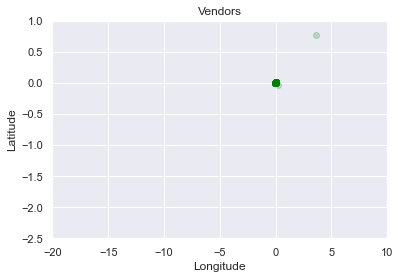

In [54]:
'''

        VENDORS LAT LONG PLOT

'''
venLY=[np.radians(vendors['longitude'])]
venLX=[np.radians(vendors['latitude'])]
plt.scatter(venLX,venLY, color="green", alpha=0.2)
plt.xlim(-20,10)
plt.ylim(-2.5,1)
plt.title("Vendors")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

Text(0, 0.5, 'Latitude')

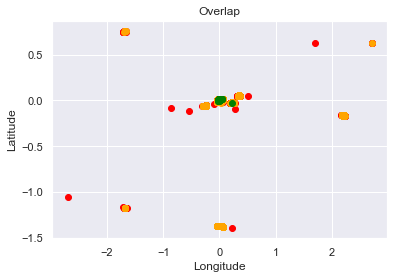

In [55]:
'''

        OVERLAPING LAT LONG PLOT ALSO FILTERING OUT OUTLIERS ABOVE THE LAT LONG LIMIT

'''
train_loc1=train_loc[(train_loc['latitude']>-180) & (train_loc['latitude']< 180) & (train_loc['longitude']>-90) & (train_loc['longitude']<90)]
test_loc1=test_loc[(test_loc['latitude']>-180) & (test_loc['latitude']< 180) & (test_loc['longitude']>-90) & (test_loc['longitude']<90)]
vendors1=vendors[(vendors['latitude']>-180) & (vendors['latitude']< 180) & (vendors['longitude']>-90) & (vendors['longitude']<90)]



trainLY=[np.radians(train_loc1['longitude'])]
trainLX=[np.radians(train_loc1['latitude'])]
plt.scatter(trainLX,trainLY, color="red")

testLY=[np.radians(test_loc1['longitude'])]
testLX=[np.radians(test_loc1['latitude'])]
plt.scatter(testLX,testLY, color="orange")




venLY=[np.radians(vendors1['longitude'])]
venLX=[np.radians(vendors1['latitude'])]
plt.scatter(venLX,venLY, color="green")

plt.title("Overlap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

In [56]:
train_ll=train_loc[['customer_id','latitude','longitude','location_number']]
test_ll=test_loc[['customer_id','latitude','longitude','location_number']]

In [57]:
train_ll=train_ll[(train_ll['latitude'].notnull())&(train_ll['longitude'].notnull())]
test_ll=test_ll[(test_ll['latitude'].notnull())&(test_ll['longitude'].notnull())]
train_ll['location_number_obj']=train_ll['location_number'].astype(str)
test_ll['location_number_obj']=test_ll['location_number'].astype(str)
train_ll['CID X LOC_NUM'] = train_ll['customer_id'] +' X '+ train_ll['location_number_obj']
test_ll['CID X LOC_NUM'] = test_ll['customer_id'] +' X '+ test_ll['location_number_obj']
train_ll=train_ll.drop(columns=['location_number_obj'])
test_ll=test_ll.drop(columns=['location_number_obj'])

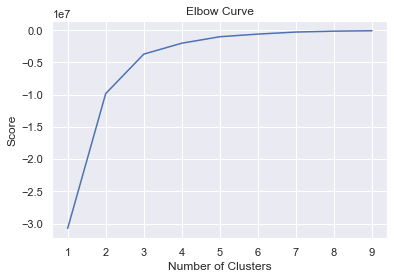

In [58]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = train_ll[['latitude']]
X_axis = train_ll[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

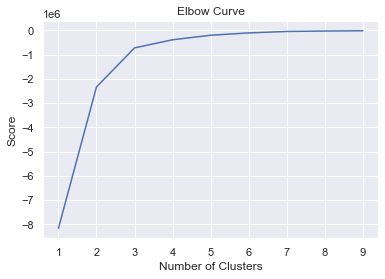

In [59]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = test_ll[['latitude']]
X_axis = test_ll[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

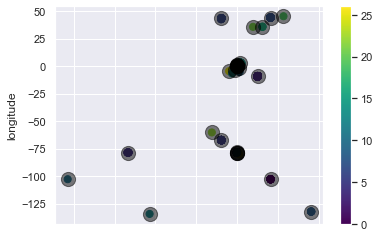

In [60]:
kmeans = KMeans(n_clusters = 27, init ='k-means++')
kmeans.fit(train_ll[train_ll.columns[1:3]]) # Compute k-means clustering.
train_ll['cluster_label'] = kmeans.fit_predict(train_ll[train_ll.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(train_ll[train_ll.columns[1:3]]) # Labels of each point
train_ll.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [61]:
centers

array([[ 2.04875000e+02, -1.02789773e+02],
       [-7.40504771e-01,  1.14013674e-01],
       [-1.24156838e+00, -7.84466506e+01],
       [ 1.25991913e+02, -9.21902426e+00],
       [-6.68045455e+02, -7.85738636e+01],
       [-9.63873821e+01, -6.71939858e+01],
       [-9.64974662e+01,  4.35126689e+01],
       [ 2.04742718e+02,  4.40937500e+01],
       [ 4.53750000e+02, -1.32250000e+02],
       [ 1.29731217e+01, -1.42941655e+00],
       [-1.03800000e+03, -1.02812500e+02],
       [-2.18091496e-01, -7.85648348e+01],
       [-5.36000000e+02, -1.34375000e+02],
       [-1.50935659e+01, -3.36294586e+00],
       [ 1.96044408e+01,  3.02536295e+00],
       [-1.50313668e-01,  6.63218120e-01],
       [ 1.55500000e+02,  3.57812500e+01],
       [ 1.94866678e+00,  6.59844294e-01],
       [-5.88829429e-02,  1.34388511e-01],
       [ 2.84250000e+02,  4.53437500e+01],
       [ 6.60237152e-01, -7.86681465e+01],
       [ 9.75000000e+01,  3.56875000e+01],
       [-1.54625000e+02, -6.03125000e+01],
       [-1.

In [62]:
'''
kmeans = KMeans(n_clusters = 8, init ='k-means++')
kmeans.fit(test_ll[test_ll.columns[1:3]]) # Compute k-means clustering.
test_ll['cluster_label'] = kmeans.fit_predict(test_ll[test_ll.columns[1:3]])
tcenters = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(test_ll[test_ll.columns[1:3]]) # Labels of each point
test_ll.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')
plt.scatter(tcenters[:, 0], tcenters[:, 1], c='black', s=200, alpha=0)
'''

"\nkmeans = KMeans(n_clusters = 8, init ='k-means++')\nkmeans.fit(test_ll[test_ll.columns[1:3]]) # Compute k-means clustering.\ntest_ll['cluster_label'] = kmeans.fit_predict(test_ll[test_ll.columns[1:3]])\ntcenters = kmeans.cluster_centers_ # Coordinates of cluster centers.\nlabels = kmeans.predict(test_ll[test_ll.columns[1:3]]) # Labels of each point\ntest_ll.plot.scatter(x = 'latitude', y = 'longitude', c=labels, s=50, cmap='viridis')\nplt.scatter(tcenters[:, 0], tcenters[:, 1], c='black', s=200, alpha=0)\n"

In [63]:
centers_d=pd.DataFrame(centers,columns=['latitude','longitude'])
centers_d=centers_d.reset_index()
centers_d=centers_d.rename(columns={'index':'cluster_label'})
centers_d.iloc[2]

cluster_label     2.000000
latitude         -1.241568
longitude       -78.446651
Name: 2, dtype: float64

In [64]:
test_ll=test_ll.assign(key=1).merge(centers_d.assign(key=1), on='key').drop('key',axis=1)
test_ll['distance'] = \
    haversine(test_ll['latitude_x'], test_ll['longitude_x'], test_ll['latitude_y'], test_ll['longitude_y'])

In [65]:
test_ll = reduce_mem_usage(test_ll)
test_ll

Mem. usage decreased to 15.50 Mb (41.0% reduction)


,customer_id,latitude_x,longitude_x,location_number,CID X LOC_NUM,cluster_label,latitude_y,longitude_y,distance
0,Z59FTQD,126.062500,-9.109375,0,Z59FTQD X 0,0,204.875000,-102.812500,12448.000000
1,Z59FTQD,126.062500,-9.109375,0,Z59FTQD X 0,1,-0.740723,0.114014,14040.000000
2,Z59FTQD,126.062500,-9.109375,0,Z59FTQD X 0,2,-1.241211,-78.437500,11456.000000
3,Z59FTQD,126.062500,-9.109375,0,Z59FTQD X 0,3,126.000000,-9.218750,10.632812
4,Z59FTQD,126.062500,-9.109375,0,Z59FTQD X 0,4,-668.000000,-78.562500,6604.000000
...,...,...,...,...,...,...,...,...,...
451354,3O8LSR3,-0.188599,0.827148,0,3O8LSR3 X 0,22,-154.625000,-60.312500,12872.000000
451355,3O8LSR3,-0.188599,0.827148,0,3O8LSR3 X 0,23,-1.517578,-0.100891,180.250000
451356,3O8LSR3,-0.188599,0.827148,0,3O8LSR3 X 0,24,0.592285,0.427002,97.562500
451357,3O8LSR3,-0.188599,0.827148,0,3O8LSR3 X 0,25,-49.031250,-4.589844,5456.000000


In [66]:
temp=test_ll
temp=temp.sort_values(by='distance', ascending=True)
temp

,customer_id,latitude_x,longitude_x,location_number,CID X LOC_NUM,cluster_label,latitude_y,longitude_y,distance
118060,T1L5K29,155.500000,35.781250,10,T1L5K29 X 10,16,155.500000,35.781250,0.000000
275759,D84NV9U,453.750000,-132.250000,5,D84NV9U X 5,8,453.750000,-132.250000,0.000000
159409,BX4UHSP,-0.740723,0.114868,1,BX4UHSP X 1,1,-0.740723,0.114014,0.098022
411714,WAETH9C,-0.057892,0.134766,4,WAETH9C X 4,18,-0.058868,0.134399,0.117920
384842,DCSLTIK,-0.218018,-78.562500,0,DCSLTIK X 0,11,-0.218140,-78.562500,0.259766
...,...,...,...,...,...,...,...,...,...
279701,9SKL48S,-96.437500,43.562500,0,9SKL48S X 0,8,453.750000,-132.250000,19712.000000
272087,19Z463S,-96.437500,43.562500,0,19Z463S X 0,8,453.750000,-132.250000,19712.000000
63188,8QOEKWQ,-96.437500,43.562500,0,8QOEKWQ X 0,8,453.750000,-132.250000,19712.000000
46259,OQWQDNE,-96.375000,43.562500,0,OQWQDNE X 0,8,453.750000,-132.250000,19728.000000


In [67]:
temp = temp.drop_duplicates(subset='CID X LOC_NUM', keep="first").reset_index()
temp=temp.drop(columns=['index'])
temp=temp.reset_index()
temp

,index,customer_id,latitude_x,longitude_x,location_number,CID X LOC_NUM,cluster_label,latitude_y,longitude_y,distance
0,0,T1L5K29,155.500000,35.781250,10,T1L5K29 X 10,16,155.500000,35.781250,0.000000
1,1,D84NV9U,453.750000,-132.250000,5,D84NV9U X 5,8,453.750000,-132.250000,0.000000
2,2,BX4UHSP,-0.740723,0.114868,1,BX4UHSP X 1,1,-0.740723,0.114014,0.098022
3,3,WAETH9C,-0.057892,0.134766,4,WAETH9C X 4,18,-0.058868,0.134399,0.117920
4,4,DCSLTIK,-0.218018,-78.562500,0,DCSLTIK X 0,11,-0.218140,-78.562500,0.259766
...,...,...,...,...,...,...,...,...,...,...
16712,16712,0LUUAJP,1.385742,-1.903320,1,0LUUAJP X 1,24,0.592285,0.427002,273.750000
16713,16713,ISSOQ1T,-665.000000,-78.562500,5,ISSOQ1T X 5,4,-668.000000,-78.562500,338.750000
16714,16714,G3NCSS1,-665.000000,-78.562500,2,G3NCSS1 X 2,4,-668.000000,-78.562500,338.750000
16715,16715,Q3IH11V,-671.500000,-78.562500,6,Q3IH11V X 6,4,-668.000000,-78.562500,384.250000


In [68]:
near_neighbor=temp
near_neighbor = reduce_mem_usage(near_neighbor)
near_neighbor

Mem. usage decreased to  0.48 Mb (16.7% reduction)


,index,customer_id,latitude_x,longitude_x,location_number,CID X LOC_NUM,cluster_label,latitude_y,longitude_y,distance
0,0,T1L5K29,155.500000,35.781250,10,T1L5K29 X 10,16,155.500000,35.781250,0.000000
1,1,D84NV9U,453.750000,-132.250000,5,D84NV9U X 5,8,453.750000,-132.250000,0.000000
2,2,BX4UHSP,-0.740723,0.114868,1,BX4UHSP X 1,1,-0.740723,0.114014,0.098022
3,3,WAETH9C,-0.057892,0.134766,4,WAETH9C X 4,18,-0.058868,0.134399,0.117920
4,4,DCSLTIK,-0.218018,-78.562500,0,DCSLTIK X 0,11,-0.218140,-78.562500,0.259766
...,...,...,...,...,...,...,...,...,...,...
16712,16712,0LUUAJP,1.385742,-1.903320,1,0LUUAJP X 1,24,0.592285,0.427002,273.750000
16713,16713,ISSOQ1T,-665.000000,-78.562500,5,ISSOQ1T X 5,4,-668.000000,-78.562500,338.750000
16714,16714,G3NCSS1,-665.000000,-78.562500,2,G3NCSS1 X 2,4,-668.000000,-78.562500,338.750000
16715,16715,Q3IH11V,-671.500000,-78.562500,6,Q3IH11V X 6,4,-668.000000,-78.562500,384.250000


In [69]:
train_ll

,customer_id,latitude,longitude,location_number,CID X LOC_NUM,cluster_label
0,02SFNJH,1.682617,-78.812500,0,02SFNJH X 0,26
1,02SFNJH,1.678711,0.766602,1,02SFNJH X 1,17
2,02SFNJH,-0.498535,0.661133,2,02SFNJH X 2,15
3,RU43CXC,0.100830,0.438232,0,RU43CXC X 0,15
4,BDFBPRD,2.523438,0.733398,0,BDFBPRD X 0,17
...,...,...,...,...,...,...
59498,9PP42SA,-0.788574,-78.500000,2,9PP42SA X 2,2
59499,9PP42SA,-1.445312,0.072571,3,9PP42SA X 3,23
59500,9PP42SA,-0.001784,0.431641,4,9PP42SA X 4,15
59501,HWELAU8,-0.066284,-78.562500,0,HWELAU8 X 0,11


In [70]:
train_ll=train_ll.rename(columns={'index':'counter'})
train_ll = reduce_mem_usage(train_ll)
train_ll

Mem. usage decreased to  1.70 Mb (9.1% reduction)


,customer_id,latitude,longitude,location_number,CID X LOC_NUM,cluster_label
0,02SFNJH,1.682617,-78.812500,0,02SFNJH X 0,26
1,02SFNJH,1.678711,0.766602,1,02SFNJH X 1,17
2,02SFNJH,-0.498535,0.661133,2,02SFNJH X 2,15
3,RU43CXC,0.100830,0.438232,0,RU43CXC X 0,15
4,BDFBPRD,2.523438,0.733398,0,BDFBPRD X 0,17
...,...,...,...,...,...,...
59498,9PP42SA,-0.788574,-78.500000,2,9PP42SA X 2,2
59499,9PP42SA,-1.445312,0.072571,3,9PP42SA X 3,23
59500,9PP42SA,-0.001784,0.431641,4,9PP42SA X 4,15
59501,HWELAU8,-0.066284,-78.562500,0,HWELAU8 X 0,11


In [71]:
near_neighbor=pd.merge(near_neighbor, train_ll, on ='cluster_label', how ='left')

In [72]:
near_neighbor

,index,customer_id_x,latitude_x,longitude_x,location_number_x,CID X LOC_NUM_x,cluster_label,latitude_y,longitude_y,distance,customer_id_y,latitude,longitude,location_number_y,CID X LOC_NUM_y
0,0,T1L5K29,155.50,35.78125,10,T1L5K29 X 10,16,155.500,35.78125,0.00,ICN6274,155.500,35.78125,5,ICN6274 X 5
1,0,T1L5K29,155.50,35.78125,10,T1L5K29 X 10,16,155.500,35.78125,0.00,YKZP6VQ,155.500,35.78125,5,YKZP6VQ X 5
2,0,T1L5K29,155.50,35.78125,10,T1L5K29 X 10,16,155.500,35.78125,0.00,6565RGW,155.500,35.78125,0,6565RGW X 0
3,1,D84NV9U,453.75,-132.25000,5,D84NV9U X 5,8,453.750,-132.25000,0.00,49OTIJG,453.750,-132.25000,6,49OTIJG X 6
4,1,D84NV9U,453.75,-132.25000,5,D84NV9U X 5,8,453.750,-132.25000,0.00,FQ2E19C,453.750,-132.25000,5,FQ2E19C X 5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129547417,16715,Q3IH11V,-671.50,-78.56250,6,Q3IH11V X 6,4,-668.000,-78.56250,384.25,MW4FJ89,-665.000,-78.62500,1,MW4FJ89 X 1
129547418,16715,Q3IH11V,-671.50,-78.56250,6,Q3IH11V X 6,4,-668.000,-78.56250,384.25,AVMHK3Q,-669.500,-78.56250,3,AVMHK3Q X 3
129547419,16715,Q3IH11V,-671.50,-78.56250,6,Q3IH11V X 6,4,-668.000,-78.56250,384.25,ES3UOC6,-671.500,-78.50000,3,ES3UOC6 X 3
129547420,16715,Q3IH11V,-671.50,-78.56250,6,Q3IH11V X 6,4,-668.000,-78.56250,384.25,XI97H1K,-668.500,-78.56250,2,XI97H1K X 2


In [73]:
near_neighbor1=near_neighbor[['index','CID X LOC_NUM_x','latitude_x','longitude_x','cluster_label','CID X LOC_NUM_y','latitude','longitude']]


In [74]:
near_neighbor1['distance'] = \
    haversine(near_neighbor1['latitude_x'], near_neighbor1['longitude_x'], near_neighbor1['latitude'], near_neighbor1['longitude'])
near_neighbor1 = reduce_mem_usage(near_neighbor1)

<ipython-input-74-6634629b363f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  near_neighbor1['distance'] = \
<ipython-input-3-01a878fa26d2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(np.int16)
<ipython-input-3-01a878fa26d2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

Mem. usage decreased to 4571.20 Mb (5.1% reduction)


In [75]:
near_neighbor1=near_neighbor1.sort_values(by='distance', ascending=True)
near_neighbor1

,index,CID X LOC_NUM_x,latitude_x,longitude_x,cluster_label,CID X LOC_NUM_y,latitude,longitude,distance
0,0,T1L5K29 X 10,155.500000,35.781250,16,ICN6274 X 5,155.500000,35.781250,0.0
23489351,2976,2D81DV3 X 0,-0.106812,-78.562500,11,FYMPMDQ X 0,-0.108337,-78.562500,0.0
69660694,8518,FIPP97Z X 1,0.009689,-78.562500,11,W0AAQ1Y X 0,-0.000477,-78.562500,0.0
50987408,6366,WMAJ1MY X 0,-0.034912,-78.562500,11,EDIN5Y6 X 1,-0.050934,-78.562500,0.0
23489357,2976,2D81DV3 X 0,-0.106812,-78.562500,11,XF9457L X 0,-0.122070,-78.562500,0.0
...,...,...,...,...,...,...,...,...,...
129466827,16655,3MM5739 X 2,-13.656250,-3.169922,13,JHGTS82 X 0,-31.390625,-6.613281,2003.0
129470167,16660,5TIF0Z1 X 2,-13.640625,-3.160156,13,JHGTS82 X 0,-31.390625,-6.613281,2005.0
129485399,16670,M4SRM9U X 0,-13.531250,-3.148438,13,JHGTS82 X 0,-31.390625,-6.613281,2016.0
129485696,16671,P2HUZSB X 0,-13.531250,-3.148438,13,JHGTS82 X 0,-31.390625,-6.613281,2016.0


In [76]:
near_neighbor2=near_neighbor1.groupby('index').head(10)

In [77]:
near_neighbor2

,index,CID X LOC_NUM_x,latitude_x,longitude_x,cluster_label,CID X LOC_NUM_y,latitude,longitude,distance
0,0,T1L5K29 X 10,155.500000,35.78125,16,ICN6274 X 5,155.500000,35.78125,0.0
23489351,2976,2D81DV3 X 0,-0.106812,-78.56250,11,FYMPMDQ X 0,-0.108337,-78.56250,0.0
69660694,8518,FIPP97Z X 1,0.009689,-78.56250,11,W0AAQ1Y X 0,-0.000477,-78.56250,0.0
50987408,6366,WMAJ1MY X 0,-0.034912,-78.56250,11,EDIN5Y6 X 1,-0.050934,-78.56250,0.0
23489357,2976,2D81DV3 X 0,-0.106812,-78.56250,11,XF9457L X 0,-0.122070,-78.56250,0.0
...,...,...,...,...,...,...,...,...,...
129547397,16713,ISSOQ1T X 5,-665.000000,-78.56250,4,ES3UOC6 X 3,-671.500000,-78.50000,697.0
129547417,16715,Q3IH11V X 6,-671.500000,-78.56250,4,MW4FJ89 X 1,-665.000000,-78.62500,697.0
129547414,16715,Q3IH11V X 6,-671.500000,-78.56250,4,6T1T7MS X 2,-665.000000,-78.56250,697.0
129547408,16714,G3NCSS1 X 2,-665.000000,-78.56250,4,ES3UOC6 X 3,-671.500000,-78.50000,697.0


In [78]:
#near_neighbor2=pd.DataFrame({"index","CID X LOC_NUM_x"})
#for i in range (0,16717)

In [79]:

for x in range(0,26):
    n=x
    subset=train_ll[train_ll['cluster_label']==n]
    #subset["counter"]=row['counter']
    #subset["latitude_a"]=row['latitude_x']
    #subset["longitude_a"]=row['longitude_x']
    #subset['distance']= haversine(subset['latitude'], subset['longitude'], subset['latitude_a'], subset['longitude_a'])
    #subset=subset.sort_values(by='distance', ascending=True).head(10)
    #near_neighbor =pd.merge(near_neighbor, subset, on ='counter', how ='left')
    print(len(subset))
    



22
6396
2989
997
11
106
74
103
7
856
1
11532
1
297
494
12230
3
2142
8057
1
3591
1
1
2568
6123
1


In [80]:
cv=orders[['customer_id','LOCATION_NUMBER','vendor_id']]
cv['location_number_obj']=cv['LOCATION_NUMBER'].astype(str)
cv['CID X LOC_NUM_y'] = cv['customer_id'] +' X '+ cv['location_number_obj']
custid=pd.Series(cv['CID X LOC_NUM_y'])
venid=pd.Series(cv['vendor_id'])
bv1=pd.DataFrame({'CID X LOC_NUM_y':custid,'vendor':venid})
bv1['vendor']=bv1['vendor'].apply(str)
fbv1=(bv1.groupby('CID X LOC_NUM_y').vendor.agg([('count', 'count'), ('vendor', ', '.join)])
   .reset_index())

<ipython-input-80-667f4e468390>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['location_number_obj']=cv['LOCATION_NUMBER'].astype(str)
<ipython-input-80-667f4e468390>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cv['CID X LOC_NUM_y'] = cv['customer_id'] +' X '+ cv['location_number_obj']


In [81]:
fbv1

,CID X LOC_NUM_y,count,vendor
0,000THBA X 0,1,148
1,002510Y X 0,1,157
2,005ECL6 X 0,2,"237, 237"
3,0075AM7 X 0,1,145
4,009UFS1 X 0,2,"193, 83"
...,...,...,...
43636,ZZVLIB5 X 2,1,225
43637,ZZWKMGG X 0,1,192
43638,ZZY3N0D X 0,1,85
43639,ZZY3N0D X 1,8,"189, 189, 86, 225, 459, 356, 419, 537"


In [82]:
near_neighbor2 =pd.merge(near_neighbor2, fbv1, on ='CID X LOC_NUM_y', how ='left')
near_neighbor2

,index,CID X LOC_NUM_x,latitude_x,longitude_x,cluster_label,CID X LOC_NUM_y,latitude,longitude,distance,count,vendor
0,0,T1L5K29 X 10,155.500000,35.78125,16,ICN6274 X 5,155.500000,35.78125,0.0,NaN,NaN
1,2976,2D81DV3 X 0,-0.106812,-78.56250,11,FYMPMDQ X 0,-0.108337,-78.56250,0.0,3.0,"106, 78, 104"
2,8518,FIPP97Z X 1,0.009689,-78.56250,11,W0AAQ1Y X 0,-0.000477,-78.56250,0.0,5.0,"195, 78, 28, 78, 78"
3,6366,WMAJ1MY X 0,-0.034912,-78.56250,11,EDIN5Y6 X 1,-0.050934,-78.56250,0.0,NaN,NaN
4,2976,2D81DV3 X 0,-0.106812,-78.56250,11,XF9457L X 0,-0.122070,-78.56250,0.0,1.0,195
...,...,...,...,...,...,...,...,...,...,...,...
167146,16713,ISSOQ1T X 5,-665.000000,-78.56250,4,ES3UOC6 X 3,-671.500000,-78.50000,697.0,1.0,159
167147,16715,Q3IH11V X 6,-671.500000,-78.56250,4,MW4FJ89 X 1,-665.000000,-78.62500,697.0,NaN,NaN
167148,16715,Q3IH11V X 6,-671.500000,-78.56250,4,6T1T7MS X 2,-665.000000,-78.56250,697.0,1.0,44
167149,16714,G3NCSS1 X 2,-665.000000,-78.56250,4,ES3UOC6 X 3,-671.500000,-78.50000,697.0,1.0,159


In [83]:
cv1=cv[['CID X LOC_NUM_y','vendor_id']]
near_neighbor3=near_neighbor2[['CID X LOC_NUM_x','CID X LOC_NUM_y']]
near_neighbor3 =pd.merge(near_neighbor3, cv1, on ='CID X LOC_NUM_y', how ='left')
near_neighbor3=near_neighbor3.drop(columns='CID X LOC_NUM_y')
custid=pd.Series(near_neighbor3['CID X LOC_NUM_x'])
venid=pd.Series(near_neighbor3['vendor_id'])
bv2=pd.DataFrame({'CID X LOC_NUM_x':custid,'vendor':venid})
bv2['vendor']=bv2['vendor'].apply(str)
fbv2=(bv2.groupby('CID X LOC_NUM_x').vendor.agg([('count', 'count'), ('vendor', ', '.join)])
   .reset_index())
fbv2

,CID X LOC_NUM_x,count,vendor
0,000IPH5 X 0,24,"148.0, 28.0, 33.0, 159.0, 78.0, 391.0, 391.0, ..."
1,002U0H9 X 0,23,"294.0, 243.0, 83.0, 294.0, 197.0, 243.0, 145.0..."
2,00ICGWM X 0,48,"105.0, 459.0, 105.0, 86.0, 84.0, 160.0, 459.0,..."
3,00ICGWM X 1,16,"105.0, nan, 86.0, 84.0, 84.0, 193.0, 189.0, 90..."
4,015LTZX X 0,10,"nan, nan, nan, nan, nan, nan, nan, nan, nan, nan"
...,...,...,...
16712,ZZR7XVG X 2,30,"85.0, 110.0, 203.0, 67.0, 310.0, 582.0, 310.0,..."
16713,ZZSJX8B X 0,18,"180.0, 176.0, 176.0, 271.0, 191.0, 547.0, nan,..."
16714,ZZUD9GZ X 0,25,"78.0, 113.0, 79.0, 79.0, 578.0, 79.0, 79.0, 19..."
16715,ZZZW5ZR X 0,18,"78.0, 78.0, 113.0, 78.0, 207.0, 106.0, 78.0, 7..."


In [117]:
v=pd.DataFrame(vendors['id'])
s=vendors['id']
g=vendors[['id','latitude','longitude']]

In [118]:
v=pd.concat([v,pd.DataFrame(columns=s)])

In [119]:
v

,id,4,13,20,23,28,33,43,44,55,66,67,75,76,78,79,81,82,83,84,85,86,90,92,104,105,106,110,113,115,134,145,148,149,154,157,159,160,161,176,180,188,189,191,192,193,195,196,197,199,201,203,207,216,221,225,231,237,243,250,259,265,271,274,288,289,294,295,298,299,300,303,304,310,356,386,391,398,401,419,459,537,547,573,575,577,578,582,583,676,679,681,841,843,845,846,849,855,856,858,907
0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [143]:
#0,2,5,10,15,30,50,100,500
a1=0
a2=0
a3=0
a4=0
a5=0
a6=0
a7=0
a8=0


for i in range(0,100):
    for j in range(0,100):
        j2=j+1
        lat1=g.iloc[i,1]
        long1=g.iloc[i,2]
        lat2=g.iloc[j,1]
        long2=g.iloc[j,2]
        q=haversine(lat1, long1, lat2, long2)
        v.iloc[i,j2]=q
        if q>0 and q<=5:
            a1=a1+1
        elif q>5 and q<=10:
            a2=a2+1
        elif q>10 and q<=15:
            a3=a3+1
        elif q>15 and q<=30:
            a4=a4+1
        elif q>30 and q<=50:
            a5=a5+1
        elif q>50 and q<=100:
            a6=a6+1
        elif q>100 and q<=500:
            a7=a7+1
        elif q>500 :
            a8=a8+1
        
    

In [138]:
v

,id,4,13,20,23,28,33,43,44,55,66,67,75,76,78,79,81,82,83,84,85,86,90,92,104,105,106,110,113,115,134,145,148,149,154,157,159,160,161,176,180,188,189,191,192,193,195,196,197,199,201,203,207,216,221,225,231,237,243,250,259,265,271,274,288,289,294,295,298,299,300,303,304,310,356,386,391,398,401,419,459,537,547,573,575,577,578,582,583,676,679,681,841,843,845,846,849,855,856,858,907
0,4.0,0,13.0261,23.6087,0.343702,120.995,10.4784,57.5211,84.2198,97.0442,121.42,53.983,1.36878,95.9697,62.1808,138.331,78.0689,22.5264,77.4643,88.2511,1.32046,78.0817,73.2155,10.757,62.7963,85.9685,136.515,71.0923,137.862,132.287,60.6892,75.8031,76.342,67.2901,79.3531,75.7191,1.32671,84.1294,103.462,19.3832,94.0448,23.7243,79.9081,59.8471,254.701,95.0229,78.6467,157.065,63.9983,325.528,71.6029,71.9363,84.3508,0.0972137,71.9205,77.9327,14533.6,84.5799,311.894,8.51744,71.9205,96.0372,28.4356,101.68,3.63253,88.4144,110.845,10.8485,22.8676,73.4852,77.6387,72.6671,110.548,68.951,81.626,88.0986,5.18478,72.9275,69.5466,80.4405,101.472,78.389,72.7813,289.698,75.9158,62.2641,129.368,54.0199,73.2513,56.3253,136.133,73.2547,10.3807,106.4,82.4629,74.6117,143.79,303.697,98.163,70.1283,1567.35
1,13.0,13.0261,0,13.3089,12.6829,108.09,2.58029,45.3889,89.9982,105.373,108.499,42.9226,14.3946,83.1023,61.656,125.421,80.3098,12.4992,83.6551,94.8211,14.3462,76.3685,73.5059,2.28504,49.8365,92.1299,123.609,58.5343,124.858,119.293,47.8237,76.1368,74.3307,54.9767,84.4369,63.1555,14.3506,89.871,107.279,9.73995,100.98,13.333,84.6399,46.8879,241.874,98.3872,80.7288,167.626,65.1645,312.484,59.1407,59.3331,90.1336,12.9292,59.3228,82.0556,14540.7,90.447,298.854,4.73462,59.3228,99.8754,15.4162,88.824,9.68058,95.0267,119.37,2.18731,12.8604,77.9786,81.6297,60.5632,119.041,56.649,86.043,94.6391,17.1463,73.7445,57.0234,78.3561,106.994,77.1654,59.9188,276.671,76.3386,66.2893,116.473,43.1074,73.3518,43.9772,123.133,73.4325,2.76504,115.279,73.9957,71.7713,153.341,290.864,85.4726,57.368,1554.14
2,20.0,23.6087,13.3089,0,23.2937,99.2853,14.7419,34.277,85.7928,103.873,99.8822,30.387,24.852,74.1591,52.3687,116.598,72.8576,1.13187,80.0342,91.3919,24.81,65.8578,64.5531,14.6254,41.7269,88.2977,114.859,48.3591,116.12,110.4,39.0502,67.161,63.6496,44.1739,79.5361,52.9369,24.8345,85.6286,100.817,4.22656,97.8612,0.217377,79.4576,38.6316,235.03,91.6243,73.1266,168.936,57.1752,305.316,48.6691,49.2666,85.9303,23.5259,49.2391,76.3247,14530.5,86.3278,291.746,17.2736,49.2391,93.5356,12.3117,79.7713,20.0084,91.6415,117.95,14.6003,0.874924,72.7166,75.7796,49.3111,117.582,45.7361,80.5142,91.1802,25.811,65.1322,46.7595,67.564,102.153,66.9857,50.9215,269.731,67.4301,60.9235,107.662,30.4511,64.2504,33.3626,114.279,64.391,14.5861,114.373,60.6457,60.5888,153.141,283.896,75.4272,47.9252,1545.51
3,23.0,0.343702,12.6829,23.2937,0,120.699,10.1347,57.1902,84.3335,97.235,121.124,53.6713,1.71231,95.6743,62.113,138.035,78.0818,22.2134,77.5882,88.3887,1.66403,77.9904,73.1743,10.4134,62.4528,86.0938,136.22,70.7546,137.471,131.896,60.3467,75.764,76.2425,66.9566,79.4889,75.3815,1.67041,84.2421,103.524,19.0688,94.1941,23.4082,79.9908,59.5038,254.506,95.0714,78.6554,157.286,63.9761,325.139,71.2669,71.5979,84.4647,0.247847,71.5822,77.9976,14533.6,84.6963,311.505,8.18041,71.5822,96.099,28.0921,101.385,3.30419,88.5532,111.044,10.505,22.5554,73.559,77.6997,72.3377,110.745,68.5738,81.7003,88.2353,5.42484,72.9473,69.2095,80.3405,101.624,78.3103,72.439,289.309,75.8791,62.3198,129.073,53.7109,73.2051,55.9906,135.742,73.2105,10.0371,106.609,82.2779,74.4907,143.985,303.503,97.778,69.7874,1567.35
4,28.0,120.995,108.09,99.2853,120.699,0,110.541,66.2552,166.052,190.208,1.54399,73.9138,122.359,25.1024,121.82,17.3403,143.322,100.379,163.005,173.368,122.264,121.972,130.612,110.274,58.206,169.407,15.5685,51.6233,16.8691,11.2586,60.3965,132.079,119.515,56.6,158.689,47.29,122.273,165.791,169.642,103.193,180.029,99.1018,157.457,61.1483,137.843,160.722,142.883,259.364,130.391,207.13,51.7703,50.5511,166.175,120.899,50.5998,152.926,14578.9,166.79,193.704,1

In [153]:
ven_dist_bin=pd.DataFrame({"Bin_Size":['(0,5]','(5,10]','(10,15]','(15,30]','(30,50]','(50,100]','(100,500]','>500'],"counts":[a1,a2,a3,a4,a5,a6,a7,a8]})

In [156]:
ven_dist_bin['%']=(ven_dist_bin['counts']/9898)*100
ven_dist_bin

,Bin_Size,counts,%
0,"(0,5]",280,2.828854
1,"(5,10]",234,2.364114
2,"(10,15]",398,4.021014
3,"(15,30]",764,7.718731
4,"(30,50]",870,8.789654
5,"(50,100]",3482,35.178824
6,"(100,500]",3476,35.118206
7,>500,394,3.980602


In [155]:
a1+a2+a3+a4+a5+a6+a7+a8

9898

In [200]:
import ast
def literal_return(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val

vendor_tag=vendors[['id','vendor_tag']]
#vendor_tag['vendor_tag1']=vendor_tag['vendor_tag']+',0'
vendor_tag = vendor_tag[vendor_tag['vendor_tag'].notna()]
vendor_tag['vendor_tag2'] = vendor_tag['vendor_tag'].apply(literal_return)
#vendor_tag['ven_t']=literal_eval(vendor_tag['vendor_tag1'])
vendor_tag=vendor_tag.drop(columns='vendor_tag')
vendor_tag['vendor_tag']=np.asarray(vendor_tag['vendor_tag2'])
vendor_tag=vendor_tag.drop(columns='vendor_tag2')
vendor_tag

,id,vendor_tag
0,4,"(2, 4, 5, 8, 91, 22, 12, 24, 16, 23)"
1,13,"(4, 41, 51, 34, 27, 15, 24, 16, 28)"
2,20,"(4, 8, 91, 10)"
3,23,"(5, 8, 30, 24)"
4,28,5
5,33,"(8, 42)"
6,43,"(1, 5, 30, 16)"
7,44,"(1, 5, 30, 16)"
8,55,"(4, 8, 22, 32, 24, 16, 28)"
9,66,"(4, 5, 8, 10, 24)"


In [215]:
vend_tag=vendors[['id','vendor_tag_name']]
vend_tag['vendor_tag_name'] = re.sub(",", " ", vend_tag['vendor_tag_name'])
vend_tag

TypeError: expected string or bytes-like object

In [216]:
data_sample=[]
def restaurant_recommend_func(location,title):   
    global data_sample       
    global cosine_sim
    global sim_scores
    global tfidf_matrix
    global corpus_index
    global feature
    global rest_indices
    global idx
    
    # When location comes from function ,our new data consist only location dataset
    data_sample = vend_tag
    
    # index will be reset for cosine similarty index because Cosine similarty index has to be same value with result of tf-idf vectorize
    data_sample.reset_index(level=0, inplace=True) 
    
    #Feature Extraction
    data_sample['Split']="X"
    for i in range(0,data_sample.index[-1]):
        split_data=re.split(r'[,]', data_sample['vendor_tag_name'][i])
        for k,l in enumerate(split_data):
            split_data[k]=(split_data[k].replace(" ", ""))
        split_data=' '.join(split_data[:])
        data_sample['Split'].iloc[i]=split_data
        
    #TF-IDF vectorizer
    #Extracting Stopword
    tfidf = TfidfVectorizer(stop_words='english')
#Replace NaN for empty string
    data_sample['Split'] = data_sample['Split'].fillna('')
#Applying TF-IDF Vectorizer
    tfidf_matrix = tfidf.fit_transform(data_sample['Split'])
    tfidf_matrix.shape
    
    # Using for see Cosine Similarty scores
    feature= tfidf.get_feature_names()
#Cosine Similarity
    # Compute the cosine similarity matrix
    cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix) 
    cosine_sim
'''    
    # Column names are using for index
    corpus_index=[n for n in data_sample['Split']]
       
    #Construct a reverse map of indices    
    indices = pd.Series(data_sample.index, index=data_sample['Restaurant Name']).drop_duplicates() 
    
    #index of the restaurant matchs the cuisines
    idx = indices[title]
#Aggregate rating added with cosine score in sim_score list.
    sim_scores=[]
    for i,j in enumerate(cosine_sim[idx]):
        k=data_sample['Aggregate rating'].iloc[i]
        if j != 0 :
            sim_scores.append((i,j,k))
            
    #Sort the restaurant names based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: (x[1],x[2]) , reverse=True)
# 10 similar cuisines
    sim_scores = sim_scores[0:10]
rest_indices = [i[0] for i in sim_scores] 
  
    data_x =data_sample[['Restaurant Name','Aggregate rating']].iloc[rest_indices]
    
    data_x['Cosine Similarity']=0
    for i,j in enumerate(sim_scores):
        data_x['Cosine Similarity'].iloc[i]=round(sim_scores[i][1],2)
   
    return data_x
# Top 10 similar restaurant with cuisine of 'Pizza Hut' restaurant in Connaught Place
restaurant_recommend_func('Connaught Place','Pizza Hut')
'''

<ipython-input-216-cc6f22d9620f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sample['Split']="X"
<ipython-input-216-cc6f22d9620f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sample['Split'].iloc[i]=split_data


TypeError: expected string or bytes-like object

In [206]:
cosine_sim

NameError: name 'cosine_sim' is not defined